In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd/content/gdrive/My Drive/VisionTransformer

/content/gdrive/My Drive/VisionTransformer


In [3]:
import torch
from torch import nn
import model
import patchdata
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import cv2

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vit = model.VisionTransformer(patch_vec_size=48, num_patches=64,
                                  latent_vec_dim=128, num_heads=8, mlp_hidden_dim=64,
                                  drop_rate=0., num_layers=12, num_classes=10).to(device)
vit.load_state_dict(torch.load('./model.pth'))                                  

<All keys matched successfully>

## 1. Linear Projection Weights

In [5]:
def minmax(x):
    m = torch.min(x)
    M = torch.max(x)
    return (M-x)/(M-m)

In [6]:
linear_embedding = vit.patchembedding.linear_proj.weight

In [7]:
# patch size = 4
# image channel = 3
# 1x(P^2C) -> linear_proj (CP^2)xD -> 1xD 저차원 매핑

# linear_embedding: (CP^2)xD
rgb_embedding_filters = linear_embedding.detach().cpu().view(3,4,4,-1).permute(3,0,1,2)

In [8]:
rgb_embedding_filters.size()

torch.Size([128, 3, 4, 4])

In [9]:
rgb_embedding_filters = minmax(rgb_embedding_filters)

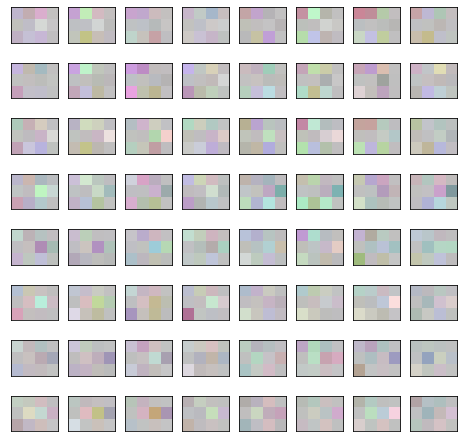

In [10]:
# 64 rgb embedding filters out of 128
fig = plt.figure(figsize=(8, 8))
for i in range(1,65):
    rgb = rgb_embedding_filters[i-1].numpy()
    ax = fig.add_subplot(8, 8, i)
    ax.axes.get_xaxis().set_visible(False) # x축 눈금 삭제
    ax.axes.get_yaxis().set_visible(False) # y축 눈금 삭제
    ax.imshow(rgb)

## 2. Positional Embedding

In [11]:
pos_embedding = vit.patchembedding.pos_embedding # [1, 65, 128]

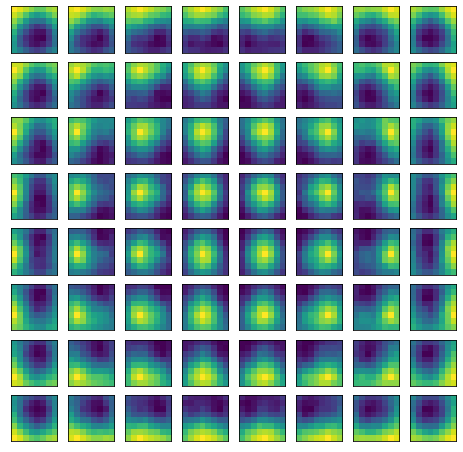

In [12]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
for i in range(1, pos_embedding.shape[1]):
    sim = F.cosine_similarity(pos_embedding[0, i:i+1], pos_embedding[0, 1:], dim=1)
    sim = sim.reshape((8, 8)).detach().cpu().numpy()
    ax = fig.add_subplot(8, 8, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

## 3. Attention 

In [13]:
def imshow(img):
    plt.figure(figsize=(4,4))   
    plt.imshow(img.permute(1,2,0).numpy())
    plt.axis('off')
    plt.show()
    plt.close()
    return img

In [14]:
def inv_normal(img):
    img  = img.reshape(64, -1, 4, 4)
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    print(img.size())
    for i in range(3):
        img[:,i,:,:] = torch.abs(img[:,i,:,:]*std[i] + mean[i])
    return img   

In [15]:
d = patchdata.Flattened2Dpatches(dataname='cifar10', img_size=32, patch_size=4,
                                     batch_size=16)
_, _, testloader = d.patchdata()
image_patch, label = iter(testloader).next()
image_patch = image_patch[12:13]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([64, 3, 4, 4])


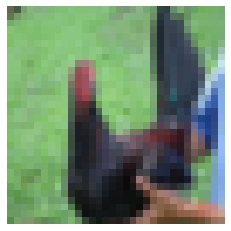

In [16]:
sample = inv_normal(image_patch)
original_img = imshow(torchvision.utils.make_grid(sample, nrow=8, padding=0))

In [17]:
print(original_img.size())

torch.Size([3, 32, 32])


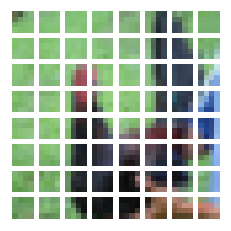

In [18]:
_ = imshow(torchvision.utils.make_grid(sample, nrow=8, padding=1, pad_value=1))

In [19]:
vit.eval()
output, attention = vit(image_patch.to(device))

In [20]:
attention = torch.stack(attention).squeeze(1) # [12, 1, 8, 65, 65] -> [12, 8, 65, 65]

In [21]:
attention_heads = attention.view(-1,65,65)
attention_heads = minmax(attention_heads)

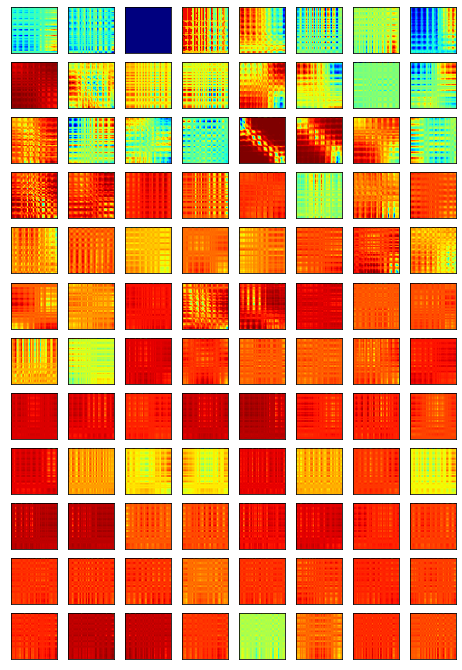

In [22]:
fig = plt.figure(figsize=(8, 12))
for i in range(1,97):
    result = attention_heads[i-1].detach().cpu().numpy()
    res_tensor = torch.Tensor(result)#.permute(1,2,0)
    ax = fig.add_subplot(12, 8, i)
    ax.axes.get_xaxis().set_visible(False) # x축 눈금 삭제
    ax.axes.get_yaxis().set_visible(False) # y축 눈금 삭제
    ax.imshow(res_tensor, vmin=np.min(result), vmax=np.max(result), cmap='jet')
    

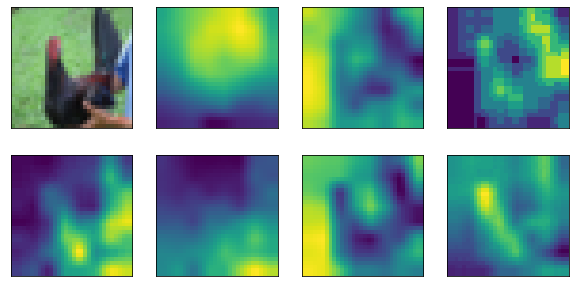

In [23]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(2, 4, 1)
ax.axes.get_xaxis().set_visible(False) # x축 눈금 삭제
ax.axes.get_yaxis().set_visible(False) # y축 눈금 삭제
ax.imshow(original_img.permute(1,2,0))
for i in range(7):  # visualize the 4th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention[0, i, 4, 1:].reshape((8, 8)).detach().cpu().numpy()
    attn_heatmap = cv2.resize(attn_heatmap,(32,32))
    ax = fig.add_subplot(2, 4, i+2)
    ax.axes.get_xaxis().set_visible(False) # x축 눈금 삭제
    ax.axes.get_yaxis().set_visible(False) # y축 눈금 삭제
    ax.imshow(attn_heatmap)

## Parameter name

In [24]:
for name, param in vit.named_parameters():
    print(name, param.size())

patchembedding.cls_token torch.Size([1, 128])
patchembedding.pos_embedding torch.Size([1, 65, 128])
patchembedding.linear_proj.weight torch.Size([128, 48])
patchembedding.linear_proj.bias torch.Size([128])
transformer.0.ln1.weight torch.Size([128])
transformer.0.ln1.bias torch.Size([128])
transformer.0.ln2.weight torch.Size([128])
transformer.0.ln2.bias torch.Size([128])
transformer.0.msa.query.weight torch.Size([128, 128])
transformer.0.msa.query.bias torch.Size([128])
transformer.0.msa.key.weight torch.Size([128, 128])
transformer.0.msa.key.bias torch.Size([128])
transformer.0.msa.value.weight torch.Size([128, 128])
transformer.0.msa.value.bias torch.Size([128])
transformer.0.mlp.0.weight torch.Size([64, 128])
transformer.0.mlp.0.bias torch.Size([64])
transformer.0.mlp.3.weight torch.Size([128, 64])
transformer.0.mlp.3.bias torch.Size([128])
transformer.1.ln1.weight torch.Size([128])
transformer.1.ln1.bias torch.Size([128])
transformer.1.ln2.weight torch.Size([128])
transformer.1.ln2